# Simulate reservoir routine
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 20-06-2024<br>

**Introduction:**<br>
This code simulates all the reservoirs included both in GloFASv4 and ResOpsUS according to the reservoir routine defined in the configuration file (attribute `simulation>model`).

The inflow time series is taken from GloFASv4 simulations, and the initial storage from the observed records.

>Note. The `Shrestha` reservoir routine requires a time series of water demand as input. Since that time series is not available, the code creates a fake demand by a transformation of the input time series.

**To do:**<br>
* [ ] When using the `Lisflood` model, some parameters could be estimated according to the records:
```Python
# storage limits
Vn_adj = get_normal_value(obs.storage) 
Vn = 1 * Vn_adj
Vtot = reservoirs.loc[ResID, 'CAP'] * 1e6
Vf = Vtot - .2 * (Vtot - Vn_adj)

# outflow limits
if obs.outflow.isnull().all():
    Qn = reservoirs.loc[ResID, 'normq_adj']
else:
    Qn = get_normal_value(obs.outflow) 
if obs.inflow.isnull().all():
    Qmin, Qnd = Qmin, Qnd = reservoirs.loc[ResID, ['minq', 'ndq']]
else:
    Q100 = return_period(obs.inflow, T=100)
    Qnd = .3 * Q100
    Qmin = obs.inflow.groupby(obs.index.year).quantile(.05).mean()
Qmin = np.min([Qmin, Qn])
```

**Ideas:**<br>


In [1]:
import sys
sys.path.append('../../src/')
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import geopandas as gpd
import yaml

from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.utils.metrics import KGEmod
from lisfloodreservoirs.utils.utils import get_normal_value, return_period

## Configuration

In [3]:
with open('config_linear_2var.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### Paths
PATH_GLOFAS = Path(cfg['paths']['GloFAS'])
PATH_RESOPS = Path(cfg['paths']['ResOpsUS'])
PATH_GRAND = Path(cfg['paths']['GRanD'])

### Reservoir model
MODEL = cfg['simulation']['model'].lower()
MODEL_CFG = cfg['simulation'].get('config', {})

# results will be saved in this path
PATH_OUT = Path(f'{MODEL}/default')
PATH_OUT.mkdir(parents=True, exist_ok=True)
print(f'Results will be saved in {PATH_OUT}')

Results will be saved in shrestha\default


## Data

### GloFAS

#### Reservoirs

In [4]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file(PATH_GLOFAS / 'tables' / 'GloFAS_reservoirs.shp') 
reservoirs.set_index('ResID', drop=True, inplace=True)
reservoirs.rename(columns={'stor': 'CAP_GLWD'}, inplace=True)

# select only those reservoirs included in ResOpsUS
resopsus = gpd.read_file('../../GIS/reservoirs_GloFAS_ResOpsUS.shp')
resopsus.set_index('ResID', drop=True, inplace=True)
mask = reservoirs.index.intersection(resopsus.index)
reservoirs = reservoirs.loc[mask]
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)

print(f'{reservoirs.shape[0]} reservoirs')

112 reservoirs


#### Time series

In [5]:
path_ts_sim = PATH_RESOPS / 'ancillary' / 'LiSFLOOD'
glofas_ts = {}
for ResID in tqdm(reservoirs.index):
    file = path_ts_sim / f'{ResID:03}.csv'
    if file.is_file():
        glofas_ts[ResID] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    else:
        print(f"{file} doesn't exist")
        
print(f'{len(glofas_ts)} reservoirs')

# check if reservoirs are missing
missing_reservoirs = reservoirs.index.difference(glofas_ts)
if len(missing_reservoirs) > 0:
    print(f'{len(missing_reservoirs)} reservoirs were not simulated in GloFAS')
    print(*missing_reservoirs)
reservoirs.drop(missing_reservoirs, axis=0, inplace=True)

# period of GloFAS simulation
start, end = glofas_ts[ResID].first_valid_index(), glofas_ts[ResID].last_valid_index()

  0%|          | 0/112 [00:00<?, ?it/s]

Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\ancillary\LiSFLOOD\068.csv doesn't exist
Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\ancillary\LiSFLOOD\179.csv doesn't exist
Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\ancillary\LiSFLOOD\185.csv doesn't exist
Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\ancillary\LiSFLOOD\197.csv doesn't exist
Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\ancillary\LiSFLOOD\296.csv doesn't exist
Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\ancillary\LiSFLOOD\323.csv doesn't exist
106 reservoirs
6 reservoirs were not simulated in GloFAS
68 179 185 197 296 323


#### Model parameters

In [6]:
# load static map of reservoirs
glofas_raster = xr.open_mfdataset((PATH_GLOFAS / 'static_maps').glob('*reservoirs*.nc'))['res'].compute()

# extract an array of reservoir ID
ids = reservoirs.index.to_list()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for ID in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == ID, drop=True)
    lon.loc[dict(ResID=ID)] = cell.lon.data[0]
    lat.loc[dict(ResID=ID)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

# extract parameter values
for par in ['adjustNormalFlood', 'ReservoirRnormqMult']:
    # load parameter map
    da = xr.open_dataset(PATH_GLOFAS / 'parameters' / f'{par}_GloFASv40.nc')[par]
    # extract values for each reservoir
    reservoirs[par] = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat']).to_pandas()

# adjust normal limit and outflow with the calibrated parameters
reservoirs['nlim_adj'] = reservoirs.nlim + reservoirs.adjustNormalFlood * (reservoirs.flim - reservoirs.nlim)
reservoirs['normq_adj'] = pd.concat((reservoirs.normq * reservoirs.ReservoirRnormqMult, reservoirs.minq + .01), axis=1).max(axis=1)

  0%|          | 0/106 [00:00<?, ?it/s]

### GRanD
#### Reservoirs

The shapefile of reservoirs in the GRanD data set is loaded to extract only the reservoir capacity reported in it.

In [7]:
# load GRanD data set
grand = gpd.read_file(PATH_GRAND / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# add GRanD capacity to the reservoirs
reservoirs['CAP_GRAND'] = grand.loc[reservoirs.GRAND_ID, 'CAP_MCM'].values

### ResOpsUS
#### Time series

In [8]:
resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    file = PATH_RESOPS / 'raw' / 'time_series_all' / f'ResOpsUS_{grand_id}.csv'
    if file.is_file():
        series_id = pd.read_csv(file, parse_dates=True, index_col='date')
        # remove empty time series
        series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
        # remove duplicated index
        series_id = series_id[~series_id.index.duplicated(keep='first')]
        # save in dictionary
        resops_ts[glofas_id] = series_id
    else:
        print(f"{file} doesn't exist")

# approximate the ResOpsUS reservoir capacity as the maximum value in the records
reservoirs['CAP_RESOPS'] = pd.Series({ID: df.storage.max() for ID, df in resops_ts.items()})

# convert storage from hm3 to m3
for ResID, df in resops_ts.items():
    df.storage *= 1e6

  0%|          | 0/106 [00:00<?, ?it/s]

### Correct reservoir capacity

In [9]:
try:
    # import DataFrame with the fraction fill and the selected data source
    ff = pd.read_excel('fraction_fill.xlsx', index_col='ResID')
except:
    # create DataFrame with the fraction fill according to each data source
    ff = pd.DataFrame(columns=['GLOFAS', 'GRAND'], dtype=float)
    ff.index.name = 'ResID'
    for ID in reservoirs.index:
        cap_resops, cap_glofas, cap_grand = reservoirs.loc[ID, ['CAP_RESOPS', 'CAP_GLWD', 'CAP_GRAND']]
        if np.isnan(cap_resops):
            continue
        ff.loc[ID, :] = cap_resops / cap_glofas, cap_resops / cap_grand
    # export
    ff.to_excel('fraction_fill.xlsx', index=True)

# define de capacity  ('CAP') as that of the most reliable source
reservoirs['CAP'] = np.nan
for ID in reservoirs.index:
    if ff.loc[ID, 'selection'] == 'GLOFAS':
        reservoirs.loc[ID, 'CAP'] = reservoirs.loc[ID, 'CAP_GLWD']
    elif ff.loc[ID, 'selection']:
        reservoirs.loc[ID, 'CAP'] = reservoirs.loc[ID, 'CAP_GRAND']

# convert storage time series into volume
for ID, df in glofas_ts.items():
    df.storage *= reservoirs.loc[ID, 'CAP'] * 1e6

## Reservoir routine
### Simulate all reservoirs

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

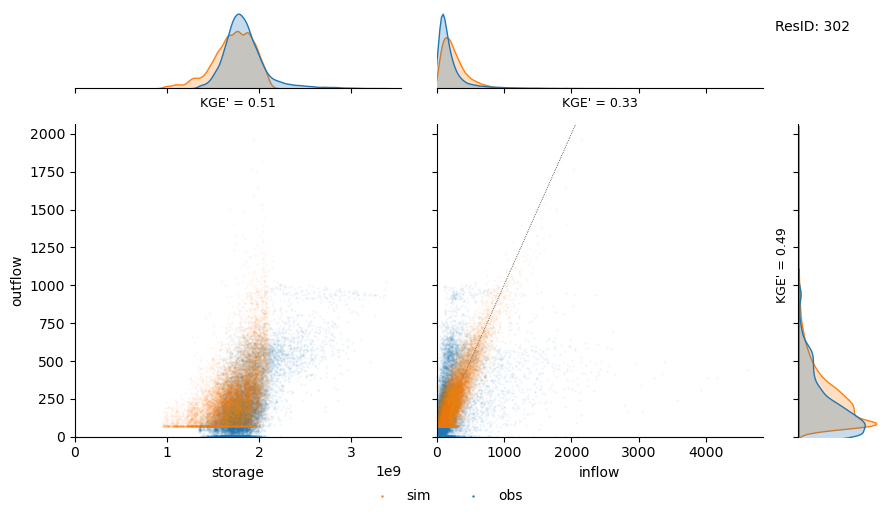

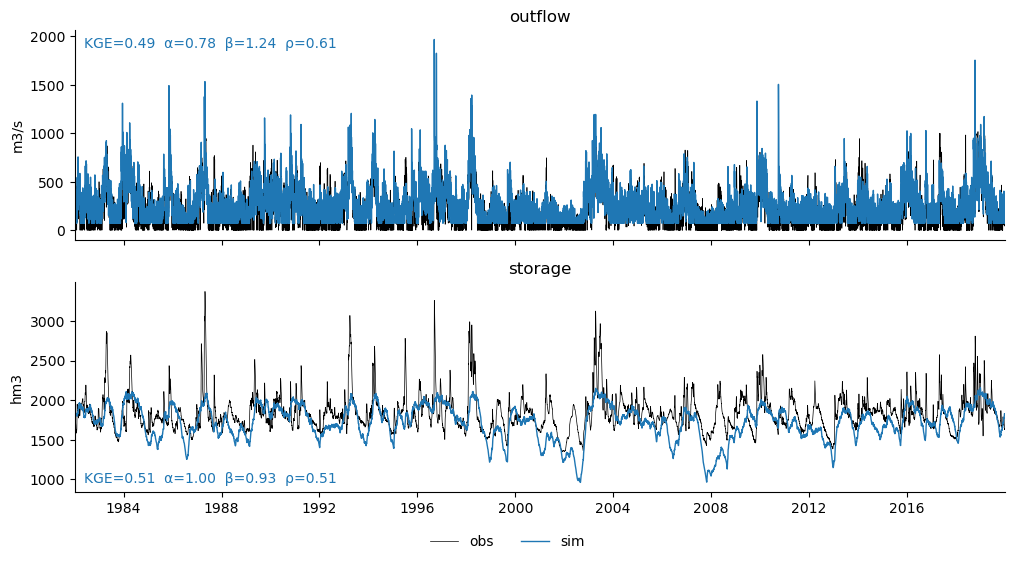

In [10]:
# GloFAS reservoir
for ResID in tqdm(reservoirs.index): # 146 #302 #273 #236 #227
    
    # file where the simulation results will be saved
    file_out = PATH_OUT / f'{ResID:03}_performance.csv'
    if file_out.is_dir():
        print(f'The file {file_out}already exists.')
        continue
        
    ## TIME SERIES
    try:
        # observed time series
        obs = resops_ts[ResID][['storage', 'inflow', 'outflow']].copy()
        obs[obs < 0] = np.nan

        # define simulation period
        if obs.outflow.isnull().all():
            print(f'Reservoir {ResID} is missing outflow records')
        elif obs.storage.isnull().all():
            print(f'Reservoir {ResID} is missing storage records')
        else:
            start_obs = max([obs[var].first_valid_index() for var in ['storage', 'outflow']])
            end_obs = min([obs[var].last_valid_index() for var in ['storage', 'outflow']])

        # define the time series 
        inflow = glofas_ts[ResID].loc[start_obs:end_obs, 'inflow']
        obs = obs.loc[start_obs:end_obs]
    except Exception as e:
        print(f'ERROR. The time series of reservoir {ResID} could not be set up\n', e)
        continue

    # storage limits (m3)
    Vmin, Vtot = reservoirs.loc[ResID, ['clim', 'CAP']]
    Vtot *= 1e6
    Vmin *= Vtot
    # outflow limits (m3/s)
    Qmin = reservoirs.loc[ResID, 'minq']
    
    if MODEL.lower() == 'linear':
        # residence time: number of days required to fill the reservoir with the mean inflow
        if (~obs.inflow.isnull()).sum() > 365 * 4:
            T = Vtot / (obs.inflow.mean() * 24 * 3600)
        elif (~obs.outflow.isnull()).sum() > 365 * 4:
            T = Vtot / (obs.outflow.mean() * 24 * 3600)
        else:
            print(f'Reservoir {ResID} does not have neither inflow nor ouflow observation, so the residence time cannot be estimated')
            continue
        kwargs = {'Vmin': Vmin, 'Vtot': Vtot, 'Qmin': Qmin, 'T': T} 
    
    elif MODEL.lower() == 'lisflood':
        # storage limits (m3)
        Vn, Vn_adj, Vf = reservoirs.loc[ResID, ['nlim', 'nlim_adj', 'flim']] * Vtot
        # outflow limits (m3)
        Qn, Qf = reservoirs.loc[ResID, ['normq_adj', 'ndq']]
        # keyword arguments
        kwargs = {'Vmin': Vmin, 'Vn': Vn, 'Vn_adj': Vn_adj, 'Vf': Vf, 'Vtot': Vtot, 'Qmin': Qmin, 'Qn': Qn, 'Qf': Qf}
    
    elif MODEL.lower() == 'hanazaki':
        # storage limits (m3)
        Vf = obs.storage[start:].quantile(.75)
        Ve = Vtot - .2 * (Vtot - Vf)
        Vmin = .5 * Vf
        # outflow limits
        Qn = inflow.mean()
        Q100 = return_period(inflow, T=100)
        Qf = .3 * Q100
        # catchment area (m2)
        grand_id = reservoirs.loc[ResID, 'GRAND_ID'].astype(int)
        A = grand.loc[grand_id, 'CATCH_SKM'] * 1e6
        # keyword arguments
        kwargs = {'Vmin': Vmin, 'Vf': Vf, 'Ve': Ve, 'Vtot': Vtot, 'Qn': Qn, 'Qf': Qf, 'A': A}
    
    elif MODEL.lower() == 'shrestha':
        # create a fake demand
        demand = .8 * inflow + np.random.normal(loc=0, scale=inflow.std() * .5, size=inflow.shape)
        demand[demand < 0] = 0
        # normal filling
        gamma = obs.storage.median() / Vtot
        # keyword arguments
        kwargs = {'Vmin': Vmin, 'Vtot': Vtot, 'Qmin': Qmin, 'avg_inflow': inflow.mean(), 'avg_demand': demand.mean(), 'gamma': gamma}
        MODEL_CFG = {'demand': demand}
        
    # export default parameters
    with open(PATH_OUT / f'{ResID:03}_default_parameters.yml', 'w') as file:
        yaml.dump(kwargs, file)
    
    # declare the reservoir
    res = get_model(MODEL, **kwargs)

    # simulate the reservoir
    sim = res.simulate(inflow, obs.storage[0], **MODEL_CFG)

    # analyse simulation
    performance = pd.DataFrame(index=['KGE', 'alpha', 'beta', 'rho'], columns=obs.columns)
    for var in performance.columns:
        try:
            performance[var] = KGEmod(obs[var], sim[var])
        except:
            continue
    performance.to_csv(file_out, float_format='%.3f')
    res.scatter(sim,
                obs,
                norm=False,
                title=f'ResID: {ResID}',
                save=PATH_OUT / f'{ResID}_scatter_default.jpg',
               )
    res.lineplot({'sim': sim},
                 obs,
                 figsize=(12, 6),
                 save=PATH_OUT / f'{ResID}_line_default.jpg',
               )

#### Effect of the residence time

<font color='red'>ONLY FOR THE LINEAR RESERVOIR!! TO BE DELETED</font>

Test the performance for different values of the residence time $T$.

In [11]:
# performance = pd.DataFrame(index=range(100, 600, 5), columns=['KGEq', 'KGEs'])
# for T in tqdm(performance.index):
    
#     # declare the reservoir
#     res = Linear(Vmin, Vtot, Qmin, T=T)

#     # simulate the reservoir
#     sim1 = res.simulate(obs.inflow, obs.storage[0])
#     performance.loc[T, :] = [KGEmod(obs[var], sim1[var])[0] for var in ['outflow', 'storage']] 

# performance = performance.astype(float)
# performance['KGE'] = (1 - (1 - performance).pow(2).sum(axis=1).pow(.5))

In [12]:
# # plot evolution
# fig, ax = plt.subplots(figsize=(4.8, 4))
# sct = ax.scatter(performance.KGEq, performance.KGEs, c=performance.index, cmap='viridis', s=3, alpha=1)
# Topt = performance.KGE.idxmax()
# ax.scatter(*performance.loc[Topt, ['KGEq', 'KGEs']], s=5, c='indianred', label='optimal')
# ax.text(performance.loc[Topt, 'KGEq'], performance.loc[Topt, 'KGEs'], f'T={Topt}d', color='indianred')
# plt.colorbar(sct, shrink=.666, label='T (days)')
# ax.set(xlim=(-1.02, 1.02),
#        xlabel=r"$KGE'_{outflow}$",
#        ylim=(-1.02, 1.02),
#        ylabel=r"$KGE'_{storage}$",
#        title=r"$KGE'_{combined}$"
#       )
# ax.legend(frameon=False, loc=2);

# plt.savefig(PATH_OUT / f'{ResID}_performance_vs_residence_time.jpg', dpi=300, bbox_inches='tight')

In [13]:
# # declare the reservoir
# res = Linear(Vmin, Vtot, Qmin, T=Topt)

# # simulate the reservoir
# sim1 = res.simulate(obs.inflow, obs.storage[0])

# # analyse simulation
# res.scatter(sim1,
#             obs,
#             norm=False,
#             title=f'ResID: {ResID}',
#             save=PATH_OUT / f'{ResID}_scatter_optimal.jpg',
#            )
# res.lineplot({'sim': sim1},
#              obs,
#              figsize=(12, 6),
#              save=PATH_OUT / f'{ResID}_line_optimal.jpg',
#            )